In [13]:
!pip install vit_keras

# CIFAR100 Image Classification 🖼


## Importing Necessary Libraries 📚


In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.layers.core import Lambda
from vit_keras import vit, utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import gc

In [3]:
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import pandas as pd
import os
%matplotlib inline

In [4]:
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

## Load Data 💾

In [6]:
(trainset, train_label), (crossdataset, cross_label) = cifar100.load_data()
train_label = to_categorical(train_label)
cross_label = to_categorical(cross_label)
trainset = (trainset/255.).astype("float32")
crossdataset = (crossdataset/255.).astype("float32")

## Data Exploration 📊

### Data Information    ℹ

In [ ]:
# Check the size of the datasets
train_size = len(trainset)
test_size = len(crossdataset)

# Get the number of classes
num_classes = len(trainset.classes)

# Count the number of samples in each class
class_counts = torch.zeros(num_classes)
for _, label in trainset:
    class_counts[label] += 1

# Display the information
print("CIFAR100 Dataset Overview:")
print("Training Set Size:", train_size)
print("Testing Set Size:", test_size)
print("Number of Classes:", num_classes)
print("Number of Samples in Each Class:")
for i, class_name in enumerate(trainset.classes):
    print(f"{class_name}: {int(class_counts[i])}")

CIFAR100 Dataset Overview:

Training Set Size: 50000

Testing Set Size: 10000

Number of Classes: 100

Number of Samples in Each Class:

apple: 500

aquarium_fish: 500

baby: 500

bear: 500

beaver: 500

bed: 500

bee: 500

beetle: 500

bicycle: 500

bottle: 500

bowl: 500

boy: 500

bridge: 500

bus: 500

butterfly: 500

camel: 500

can: 500

castle: 500

caterpillar: 500

cattle: 500

chair: 500

chimpanzee: 500

clock: 500

cloud: 500

cockroach: 500

couch: 500

crab: 500

crocodile: 500

cup: 500

dinosaur: 500

dolphin: 500

elephant: 500

flatfish: 500

forest: 500

fox: 500

girl: 500

hamster: 500

house: 500

kangaroo: 500

keyboard: 500

lamp: 500

lawn_mower: 500

leopard: 500

lion: 500

lizard: 500

lobster: 500

man: 500

maple_tree: 500

motorcycle: 500

mountain: 500

mouse: 500

mushroom: 500

oak_tree: 500

orange: 500

orchid: 500

otter: 500

palm_tree: 500

pear: 500

pickup_truck: 500

pine_tree: 500

plain: 500

plate: 500

poppy: 500

porcupine: 500

possum: 50

### Class Distribution

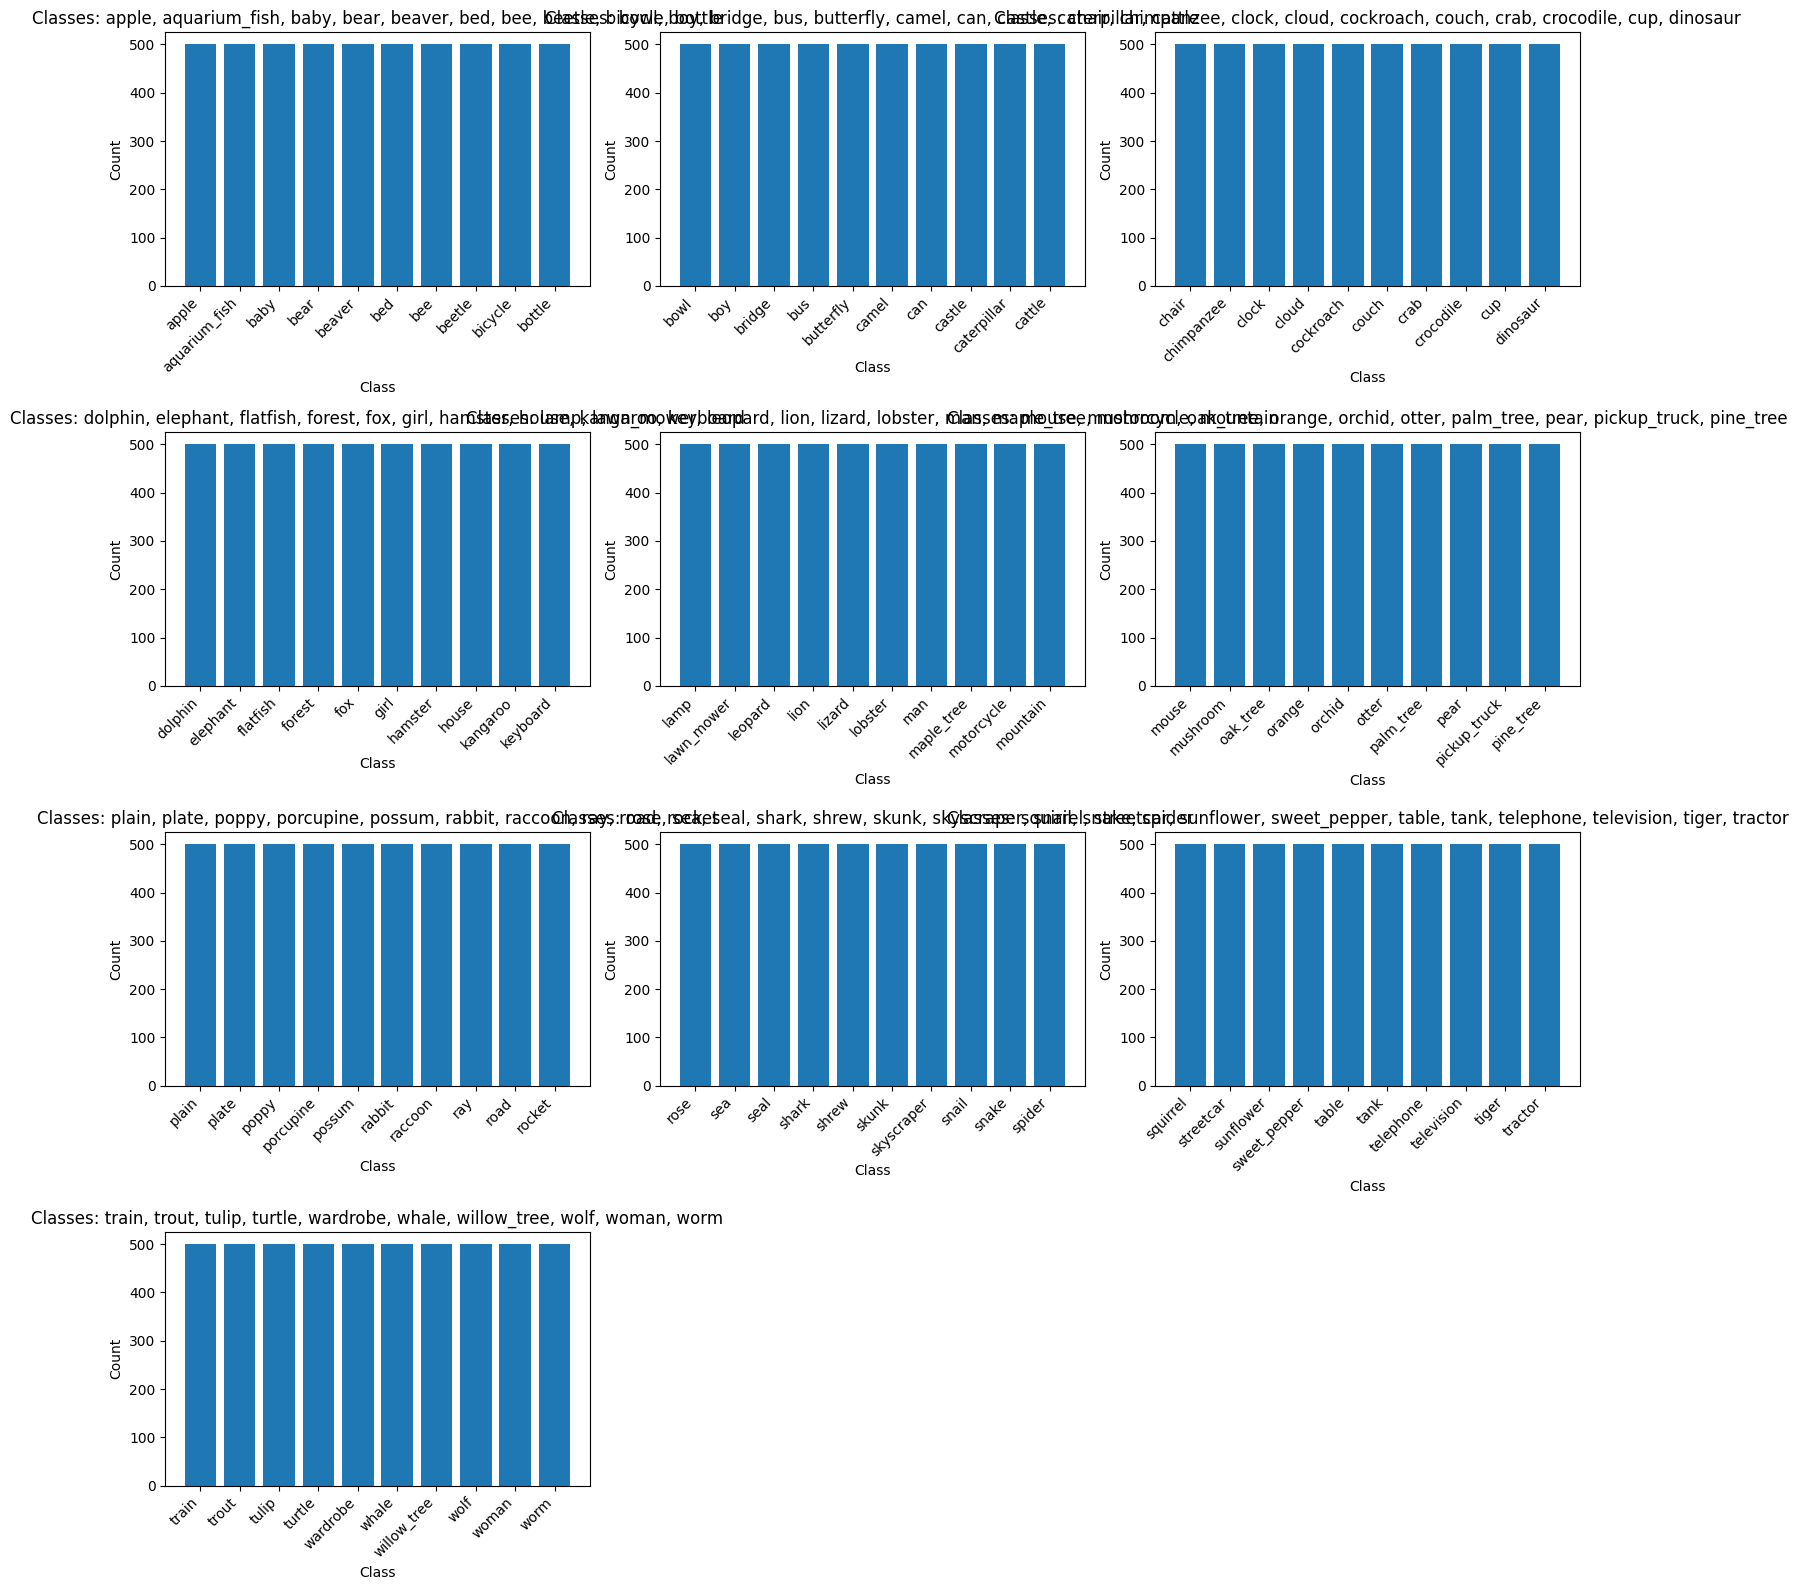

In [ ]:
# Get class names and counts
class_names = trainset.classes
class_counts = [0] * len(class_names)

# Count instances of each class
for _, target in trainset:
    class_counts[target] += 1

# Group classes in sets of 10
grouped_classes = [class_names[i:i+10] for i in range(0, len(class_names), 10)]
num_groups = len(grouped_classes)

# Plot class distribution with 3 plots in each row
groups_per_row = 3
rows = (num_groups + groups_per_row - 1) // groups_per_row

fig, axes = plt.subplots(rows, groups_per_row, figsize=(15, 4 * rows))

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        group_idx = i * groups_per_row + j
        if group_idx < num_groups:
            group_classes = grouped_classes[group_idx]
            group_counts = [class_counts[class_names.index(cls)] for cls in group_classes]

            ax.bar(group_classes, group_counts)
            ax.set_xlabel('Class')
            ax.set_ylabel('Count')
            ax.set_title(f'Classes: {", ".join(group_classes)}')

            x_ticks_positions = np.arange(len(group_classes))
            ax.set_xticks(x_ticks_positions)
            ax.set_xticklabels(group_classes, rotation=45, ha='right')  # Set xtick labels with rotation

            ax.xaxis.set_major_locator(plt.FixedLocator(x_ticks_positions))  # Set the tick positions
        else:
            ax.axis('off')

plt.tight_layout()
plt.show()


### Image Statistics

In [ ]:
# Calculate mean and standard deviation
mean = tf.reduce_mean(trainset, axis=(0, 1, 2))
std = tf.math.reduce_std(trainset, axis=(0, 1, 2))

print(f"Mean of pixel values: {mean}")
print(f"Standard deviation of pixel values: {std}")

Mean of pixel values: tensor([ 0.0142, -0.0269, -0.1182])

Standard deviation of pixel values: tensor([0.5347, 0.5129, 0.5523])


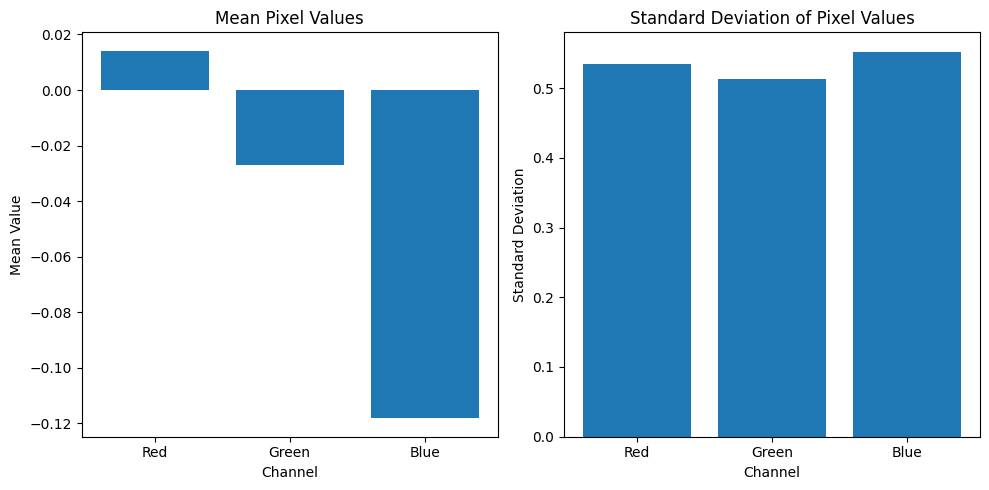

In [ ]:
# Class names for the channels
channel_names = ['Red', 'Green', 'Blue']

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the mean values for each channel
axs[0].bar(channel_names, mean)
axs[0].set_xlabel('Channel')
axs[0].set_ylabel('Mean Value')
axs[0].set_title('Mean Pixel Values')

# Plot the standard deviation values for each channel
axs[1].bar(channel_names, std)
axs[1].set_xlabel('Channel')
axs[1].set_ylabel('Standard Deviation')
axs[1].set_title('Standard Deviation of Pixel Values')

# Adjust the layout for better visualization
plt.tight_layout()

# Display the plots
plt.show()

### Pixel Distribution ⬛ ⬛ ⬛

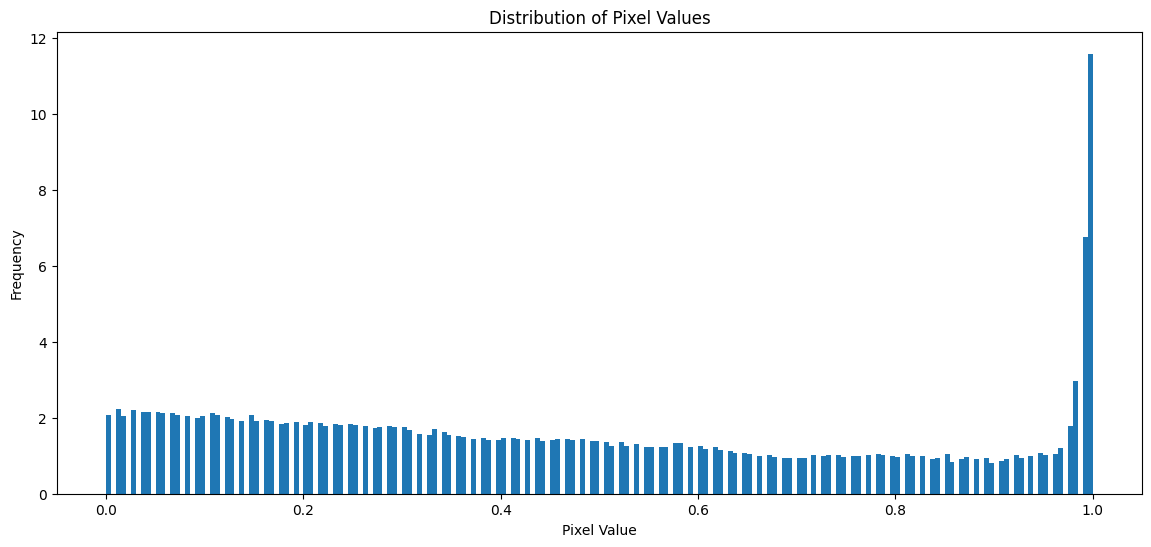

In [ ]:
import matplotlib.pyplot as plt

# Get the first batch of data
data_iter = iter(trainloader)
images, _ = next(data_iter)

# Flatten the images
flattened_images = images.view(-1)

# Create a larger figure
plt.figure(figsize=(14, 6))  #Adjust the size

# Plot the distribution of pixel values
plt.hist(flattened_images.numpy(), bins=200, range=(0, 1), density=True)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Pixel Values')

# Show the plot
plt.show()


### Channel-Wise Pixel Distribution 🟥 🟩 🟦

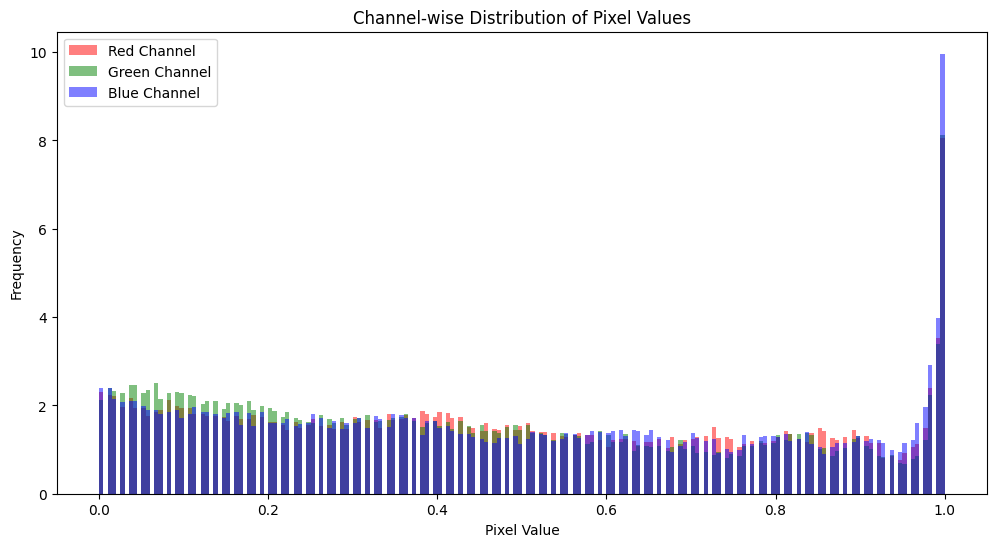

In [ ]:
# Calculate the mean of pixel values for each color channel
mean_channel = np.mean(images.numpy(), axis=(0, 2, 3))

# Create a larger figure
plt.figure(figsize=(12, 6))

# Plot the distribution of pixel values for each color channel
colors = ['red', 'green', 'blue']
for i, color in enumerate(['Red', 'Green', 'Blue']):
    channel_pixels = images[:, i, :, :].reshape(-1)  # Use reshape instead of view
    plt.hist(channel_pixels.numpy(), bins=200, range=(0, 1), density=True, alpha=0.5, label=f'{color} Channel', color=colors[i])

plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Channel-wise Distribution of Pixel Values')
plt.legend()

# Show the plot
plt.show()

## Data Visualization 🖼️

* We could take a look at how our data originally is vs how our model will see it (after normilizaion)
* We should also take. alook at the shape of our input image

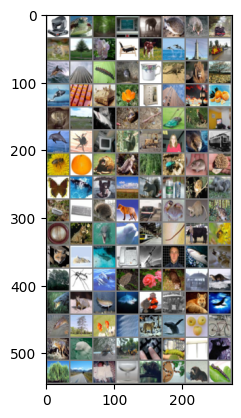

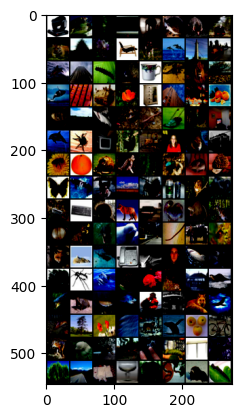

torch.Size([3, 32, 32])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, un):
    if(un):
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images), True)
imshow(torchvision.utils.make_grid(images), False)
print(images[0].shape)

##Data Augmentation 📁

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, random_state=seed, shuffle=True)

In [ ]:
batch_size = 32
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
#Generate batches of augmented images
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

## Model Architecture 👷

* We used a pre-trained ViT-B16 model as a feature extractor.
* Its base layers are frozen to retain the prelearned features.
* Added a custom top layer to the ViT model that consists of Flatten, BatchNormalization, and Dense layers.


In [ ]:
input_shape = (32, 32, 3)
image_size = 256
num_classes = 100

def build_model():
    inputs = Input(shape=input_shape)

    #Resizing images to 256x256
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (image_size, image_size)))(inputs)

    base_model = vit.vit_b16(image_size=image_size, activation="sigmoid", pretrained=True, include_top=False, pretrained_top=False)

    #Set false for transfer learning
    base_model.trainable = False

    #Add a custom top layer to the ViT model that consists of Flatten, BatchNormalization, and Dense layers
    x = base_model(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation=tfa.activations.gelu)(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation="softmax")(x)

    model_final = Model(inputs=inputs, outputs=outputs)
    return model_final

## Train The Top Layers Separately 🔝

In [ ]:
# Training top layer
model = build_model()
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         

                                                                 

 lambda_2 (Lambda)           (None, 256, 256, 3)       0         

                                                                 

 vit-b16 (Functional)        (None, 768)               85844736  

                                                                 

 flatten_2 (Flatten)         (None, 768)               0         

                                                                 

 batch_normalization_4 (Batc  (None, 768)              3072      

 hNormalization)                                                 

                                                                 

 dense_4 (Dense)             (None, 32)                24608     

                                           

In [ ]:
best_accuracy = 0.0  # Initialize best accuracy
best_model_path = '/kaggle/working/best_model.h5'  # Path to save the best model

In [ ]:
for epoch in range(10):
    model.fit(train_generator, steps_per_epoch=200, epochs=1, validation_data=(X_valid, y_valid))
    gc.collect()  #garbage collector to free up memory

    # Evaluate model on validation data
    validation_accuracy = model.evaluate(X_valid, y_valid, verbose=0)[1]

    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        model.save(best_model_path)  # Save the best model checkpoint

    print(f"Epoch {epoch + 1} - Validation Accuracy: {validation_accuracy:.4f}, Best Accuracy: {best_accuracy:.4f}")

print("Training complete.")


200/200 [==============================] - 404s 2s/step - loss: 3.7501 - accuracy: 0.1900 - val_loss: 2.4894 - val_accuracy: 0.4073

Epoch 1 - Validation Accuracy: 0.4073, Best Accuracy: 0.4073

200/200 [==============================] - 349s 2s/step - loss: 2.5341 - accuracy: 0.3848 - val_loss: 1.7074 - val_accuracy: 0.5537

Epoch 2 - Validation Accuracy: 0.5537, Best Accuracy: 0.5537

200/200 [==============================] - 350s 2s/step - loss: 2.0713 - accuracy: 0.4669 - val_loss: 1.4788 - val_accuracy: 0.5995

Epoch 3 - Validation Accuracy: 0.5995, Best Accuracy: 0.5995

200/200 [==============================] - 388s 2s/step - loss: 1.9326 - accuracy: 0.4884 - val_loss: 1.3845 - val_accuracy: 0.6176

Epoch 4 - Validation Accuracy: 0.6176, Best Accuracy: 0.6176

200/200 [==============================] - 388s 2s/step - loss: 1.8328 - accuracy: 0.5083 - val_loss: 1.2848 - val_accuracy: 0.6440

Epoch 5 - Validation Accuracy: 0.6440, Best Accuracy: 0.6440

200/200 [================

## Fine-tuning The Whole Model ⏬


* After training the top layers, the model is reconfigured for fine-tuning.
* All layers in the model are set to be trainable to allow for the adjustment of both the top layers and the prelearned ViT layers.
* The model is compiled again with a lower learning rate of 0.001.
* The model is trained for 40 epochs on the training data, which now includes the prelearned features of the ViT layers.



In [ ]:
# Make all layers trainable
for layer in model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Show model summary
model.summary()

Model: "model_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         

                                                                 

 lambda_2 (Lambda)           (None, 256, 256, 3)       0         

                                                                 

 vit-b16 (Functional)        (None, 768)               85844736  

                                                                 

 flatten_2 (Flatten)         (None, 768)               0         

                                                                 

 batch_normalization_4 (Batc  (None, 768)              3072      

 hNormalization)                                                 

                                                                 

 dense_4 (Dense)             (None, 32)                24608     

                                           

In [ ]:
best_model_path2 = '/kaggle/working/best_model2.h5'  # Path to save the best model

**1. First, The Model Is Trained For 20 Epochs**

In [ ]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=200,
                    epochs=20,
                    validation_data=(X_valid, y_valid))
# Calculate test accuracy
test_pred = model.predict(crossdataset)
test_accuracy = accuracy_score(np.argmax(cross_label, axis=1), np.argmax(test_pred, axis=1))
print("Test Accuracy: ", test_accuracy)

# Save the best model
if test_accuracy > best_accuracy:
    best_accuracy = test_accuracy
    model.save(best_model_path2)

Epoch 1/20

200/200 [==============================] - 607s 3s/step - loss: 0.5270 - accuracy: 0.8472 - val_loss: 0.4207 - val_accuracy: 0.8778

Epoch 2/20

200/200 [==============================] - 606s 3s/step - loss: 0.5161 - accuracy: 0.8545 - val_loss: 0.4152 - val_accuracy: 0.8766

Epoch 3/20

200/200 [==============================] - 568s 3s/step - loss: 0.5080 - accuracy: 0.8541 - val_loss: 0.4203 - val_accuracy: 0.8786

Epoch 4/20

200/200 [==============================] - 567s 3s/step - loss: 0.5186 - accuracy: 0.8504 - val_loss: 0.4067 - val_accuracy: 0.8847

Epoch 5/20

200/200 [==============================] - 605s 3s/step - loss: 0.4491 - accuracy: 0.8678 - val_loss: 0.3959 - val_accuracy: 0.8846

Epoch 6/20

200/200 [==============================] - 568s 3s/step - loss: 0.4336 - accuracy: 0.8733 - val_loss: 0.3975 - val_accuracy: 0.8878

Epoch 7/20

200/200 [==============================] - 605s 3s/step - loss: 0.4596 - accuracy: 0.8664 - val_loss: 0.3899 - val_acc

**2. Then Retrained For Another 20 Epochs**

In [ ]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=200,
                    epochs=20,
                    validation_data=(X_valid, y_valid))

# Calculate test accuracy
test_pred = model.predict(crossdataset)
test_accuracy = accuracy_score(np.argmax(cross_label, axis=1), np.argmax(test_pred, axis=1))
print("Test Accuracy: ", test_accuracy)

# Save the best model
if test_accuracy > best_accuracy:
    best_accuracy = test_accuracy
    model.save(best_model_path2)

Epoch 1/20

200/200 [==============================] - 568s 3s/step - loss: 0.3084 - accuracy: 0.9095 - val_loss: 0.3494 - val_accuracy: 0.9021

Epoch 2/20

200/200 [==============================] - 567s 3s/step - loss: 0.3261 - accuracy: 0.8998 - val_loss: 0.3350 - val_accuracy: 0.9054

Epoch 3/20

200/200 [==============================] - 605s 3s/step - loss: 0.2871 - accuracy: 0.9123 - val_loss: 0.3524 - val_accuracy: 0.9014

Epoch 4/20

200/200 [==============================] - 570s 3s/step - loss: 0.3009 - accuracy: 0.9122 - val_loss: 0.3506 - val_accuracy: 0.9028

Epoch 5/20

200/200 [==============================] - 606s 3s/step - loss: 0.3110 - accuracy: 0.9094 - val_loss: 0.3329 - val_accuracy: 0.9058

Epoch 6/20

200/200 [==============================] - 607s 3s/step - loss: 0.2870 - accuracy: 0.9128 - val_loss: 0.3365 - val_accuracy: 0.9038

Epoch 7/20

200/200 [==============================] - 606s 3s/step - loss: 0.2897 - accuracy: 0.9173 - val_loss: 0.3480 - val_acc

## Inference Time ⏳

In [ ]:
import time
start=time.time()
predict_test = model.predict(crossdataset)
end=time.time()
print(end - start)

0.0022368431091308594


## Plotting Curves For First 20 Epochs 📈 📉

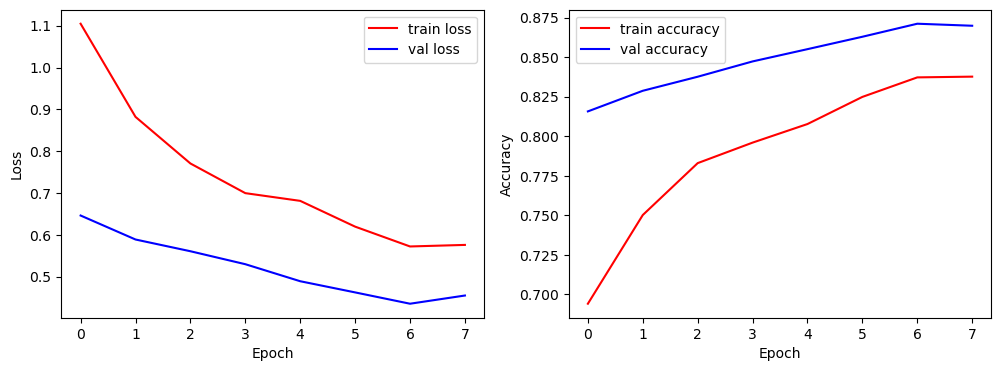

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax[0].plot(history.history["loss"], c="r", label="train loss")
ax[0].plot(history.history["val_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(history.history["val_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

## Plotting Curves For Second 20 Epochs 📈 📉

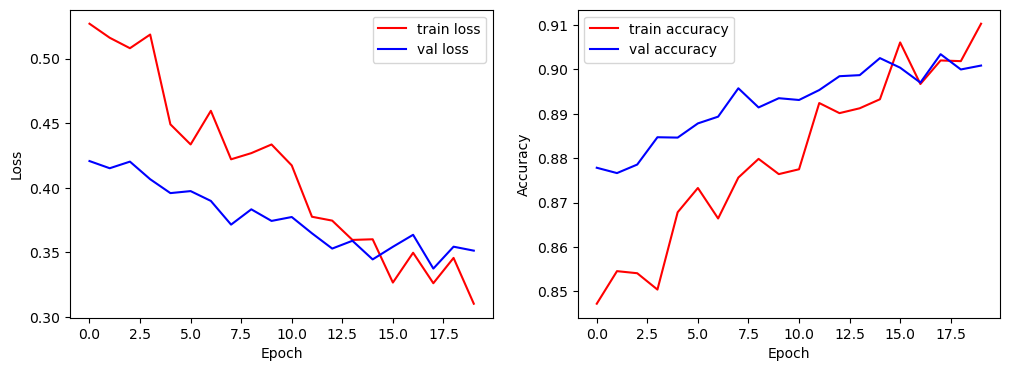

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax[0].plot(history.history["loss"], c="r", label="train loss")
ax[0].plot(history.history["val_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(history.history["val_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

## Getting model Predictions 📝


In [ ]:
y_pred=model.predict(crossdataset)
y_true=np.argmax(y_pred,axis=1)
y_true= pd.Series(y_true,name="Label")

313/313 [==============================] - 180s 574ms/step


## Saving Submission Data 💽

In [ ]:
submission = pd.concat([pd.Series(range(0,10000),name = "ID"),y_true],axis = 1)

submission.to_csv("predictions.csv",index=False)